In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
from tqdm import tqdm
from PIL import Image
import io

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB2
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg16 import VGG16
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D, Average, Input, Concatenate, GlobalMaxPooling2D,BatchNormalization
from keras.applications import ResNet50,MobileNet, DenseNet201, InceptionV3, DenseNet121, DenseNet169, InceptionResNetV2, NASNetMobile
from keras.applications.xception import Xception
from keras.models import Model
from keras.optimizers import Adam
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
from IPython.display import display, clear_output
import ipywidgets as widgets

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [4]:
labels = ['Benign', 'Melanoma']
X_train = []
Y_train  = []
X_test = []
Y_test = []
image_size=224

for label in labels:
    trainPath = os.path.join('/content/drive/MyDrive/ISBI2017/train',label)
    for file in tqdm(os.listdir(trainPath)):
        image = cv2.imread(os.path.join(trainPath, file))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (image_size, image_size))
        X_train.append(image)
        Y_train.append(label)

    testPath = os.path.join('/content/drive/MyDrive/ISBI2017/test',label)
    for file in tqdm(os.listdir(testPath)):
        image = cv2.imread(os.path.join(testPath, file))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (image_size, image_size))
        X_test.append(image)
        Y_test.append(label)

X_train = np.array(X_train)
X_test = np.array(X_test)

100%|██████████| 207/207 [00:04<00:00, 48.46it/s] 


In [5]:
X_train, Y_train = shuffle(X_train, Y_train, random_state=1010)
X_test, Y_test = shuffle(X_test, Y_test, random_state=1010)

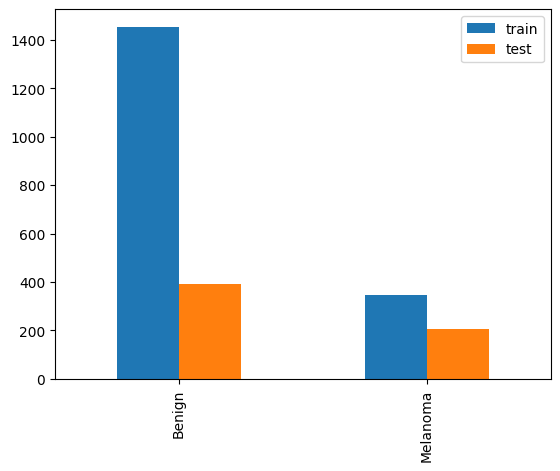

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
_, train_counts = np.unique(Y_train, return_counts=True)
_, test_counts = np.unique(Y_test, return_counts=True)
pd.DataFrame({'train': train_counts,
                    'test': test_counts},
             index=labels
            ).plot.bar()
plt.savefig('dataset',dpi=400)
plt.show()

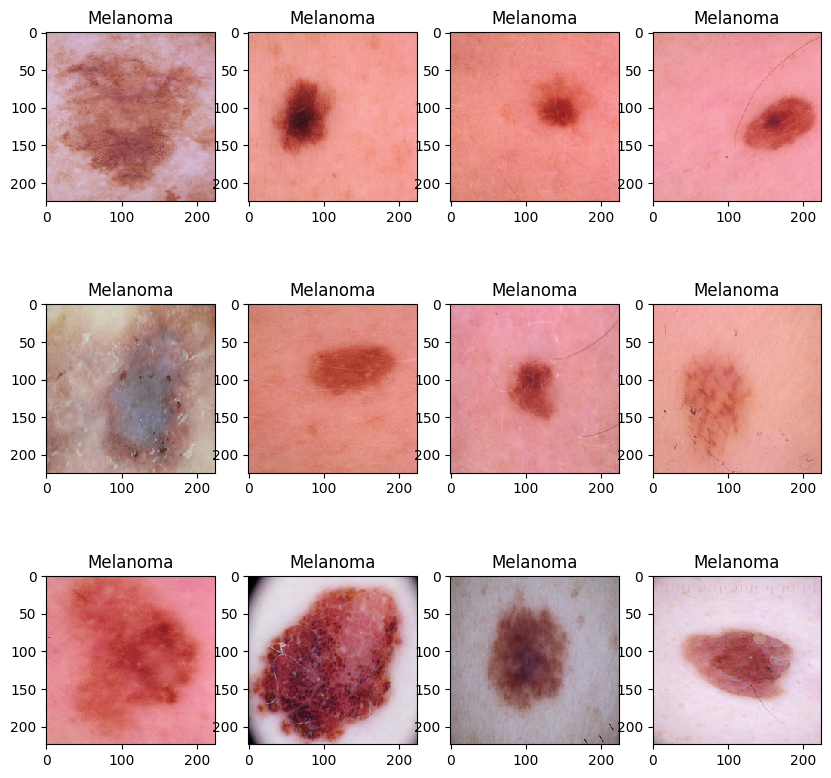

In [8]:
plt.style.use('default')
w=60
h=40
fig=plt.figure(figsize=(10, 10))
columns = 4
rows = 3

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    if np.argmax(Y_train[i]) == 1:
        ax.title.set_text('Benign')
    else:
        ax.title.set_text('Melanoma')
    plt.imshow(X_train[i], interpolation='nearest')
plt.savefig('samples',dpi=400)
plt.show()

In [9]:
y_train_ = []
for i in Y_train:
    y_train_.append(labels.index(i))
Y_train = y_train_

Y_train = tf.keras.utils.to_categorical(Y_train)

y_test_ = []
for i in Y_test:
    y_test_.append(labels.index(i))
Y_test = y_test_

Y_test = tf.keras.utils.to_categorical(Y_test)

In [ ]:
X_train = X_train.reshape(900,3*224*224)

In [ ]:
from imblearn.over_sampling import SMOTE
sm_train = SMOTE(random_state=42, sampling_strategy=1)
X_train, Y_train = sm_train.fit_resample(X_train, Y_train)
X_train.shape

(1454, 150528)

In [ ]:
X_train = X_train.reshape(1454,224,224,3)
Y_train = Y_train.reshape(1454,)

In [10]:
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.1, random_state=1010)

In [11]:
BATCH_SIZE = 32

# Using original generator
train_generator = ImageDataGenerator(
        zoom_range=2.5,  # set range for random zoom
        rotation_range = 90,
        shear_range = 0.5,
        width_shift_range=0.5,
        height_shift_range=0.5,
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True  # randomly flip images
    )

In [12]:
IMAGE_SIZE=224
# Model
input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)
inputs = Input(input_shape)

vgg16 = VGG16(include_top=False, input_shape=input_shape)(inputs)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [14]:
outputs = GlobalAveragePooling2D()(vgg16)
outputs = Dropout(0.4)(outputs)
outputs = BatchNormalization()(outputs)
outputs = Dense(256,activation='relu')(outputs)
outputs = Dense(128,activation='relu')(outputs)
outputs = Dropout(0.2)(outputs)
outputs = Dense(2, activation='softmax')(outputs)

model = Model(inputs, outputs)
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,881,218 (56.77 MB)

 Trainable params: 14,880,194 (56.76 MB)

 Non-trainable params: 1,024 (4.00 KB)

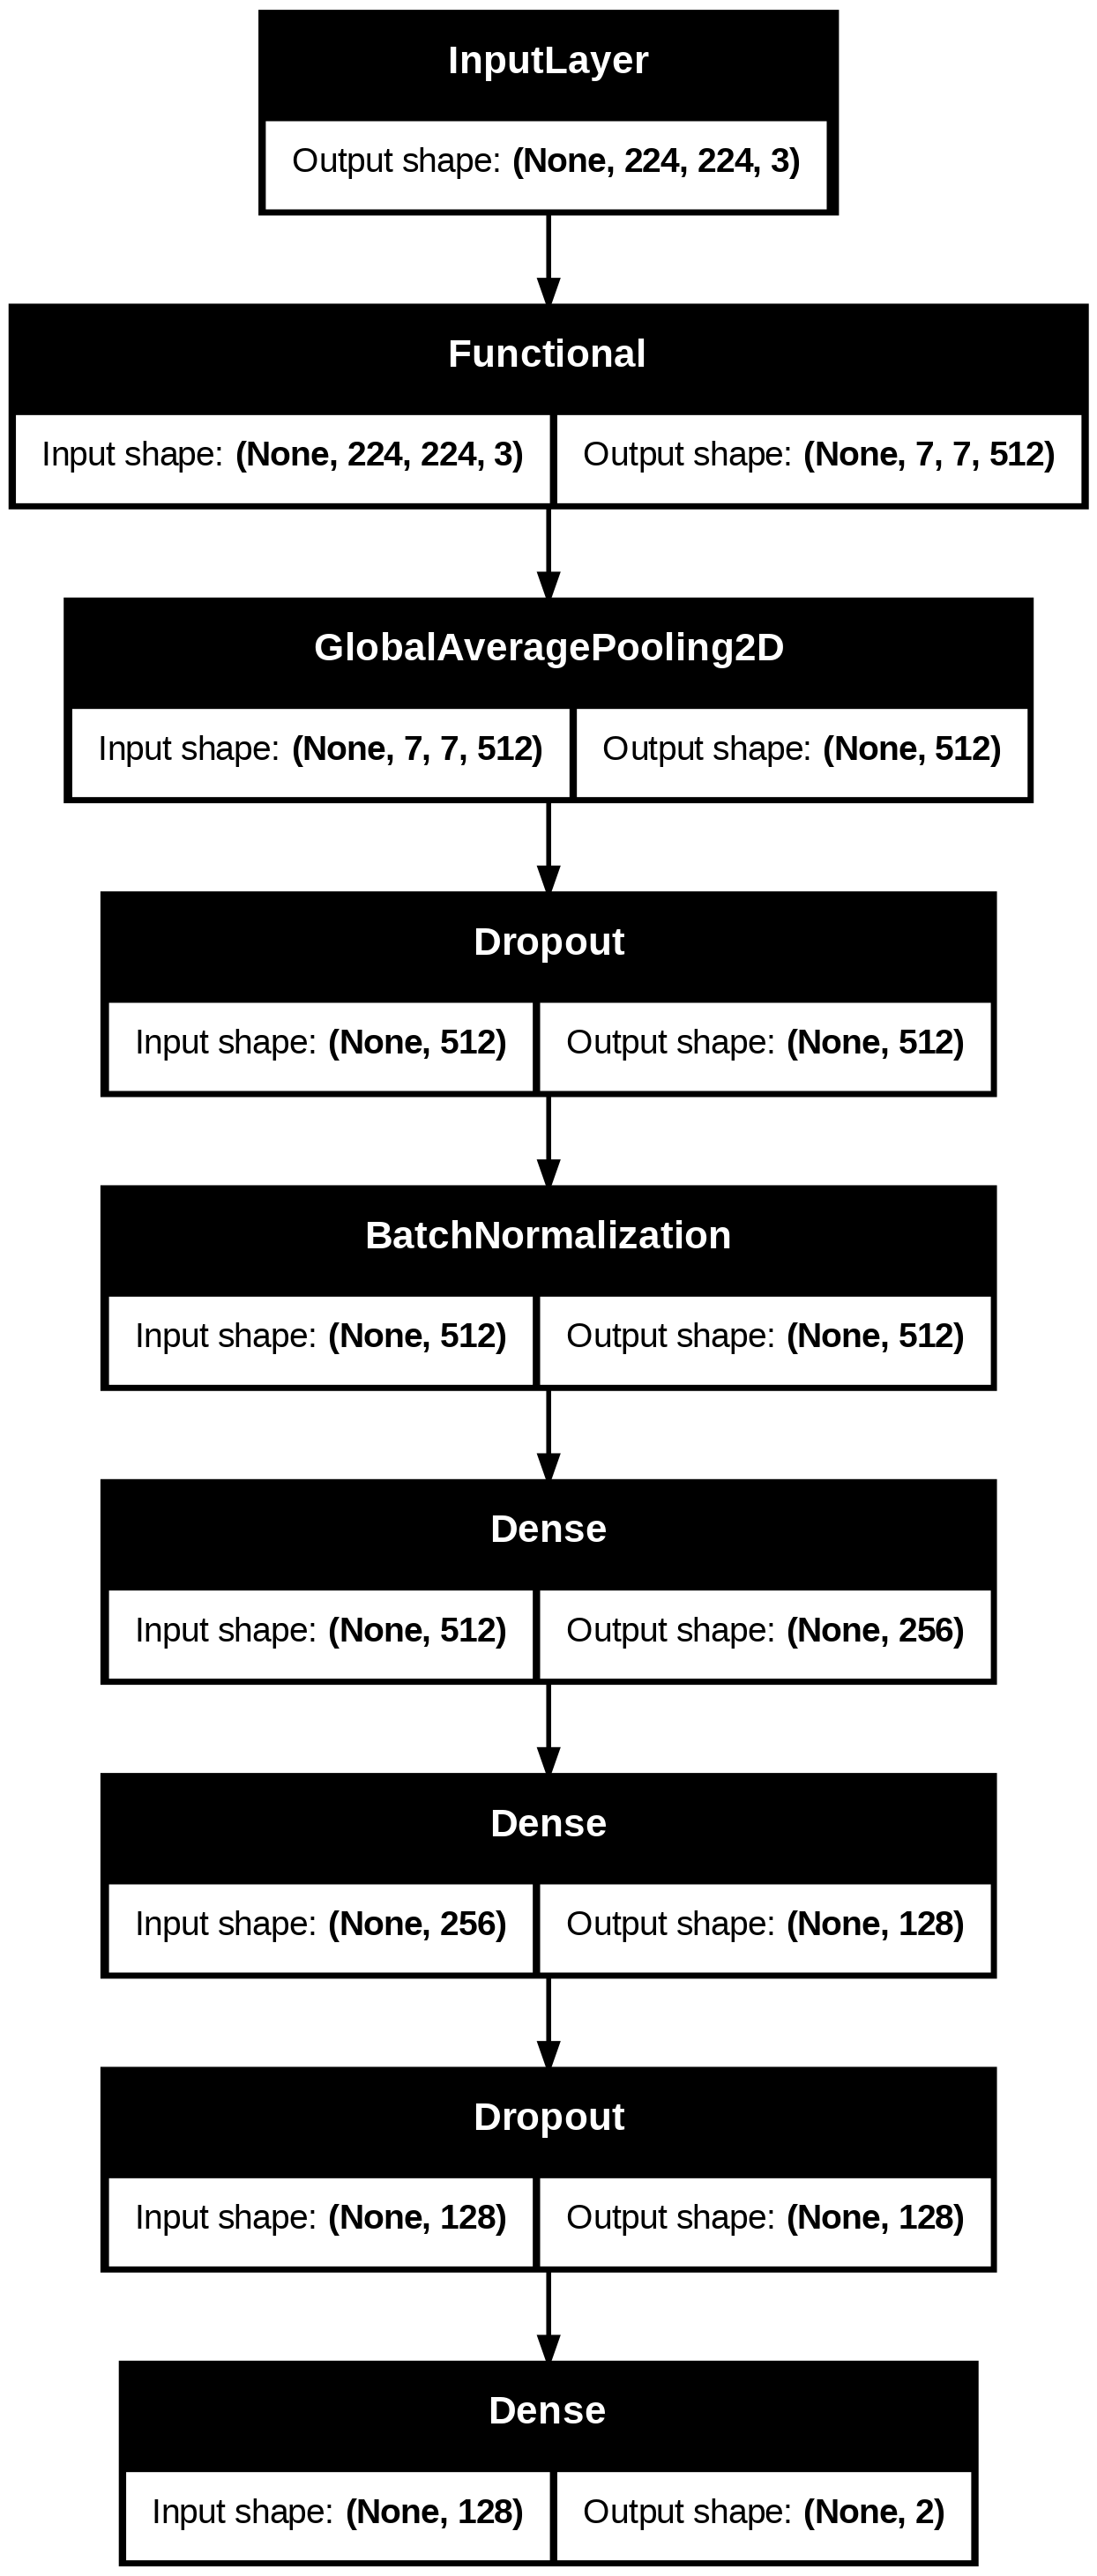

In [15]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True, to_file='VGG16Net.png')

In [19]:
# Learning Rate Reducer
learn_control = ReduceLROnPlateau(monitor='val_acc', patience=5,
                                  verbose=1,factor=0.2, min_lr=1e-7)

# Checkpoint
filepath="/content/drive/MyDrive/SkinVGG16_ISBI2017.keras"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')


In [21]:
history = model.fit(
    train_generator.flow(X_train, Y_train, batch_size=BATCH_SIZE),
    steps_per_epoch=X_train.shape[0] // BATCH_SIZE,
    epochs=20,
    validation_data=(X_val, Y_val),
    callbacks=[learn_control, checkpoint]
)

Epoch 1/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 121s 2s/step - accuracy: 0.7121 - loss: 0.5779 - val_accuracy: 0.7833 - val_loss: 0.9177 - learning_rate: 1.0000e-04
Epoch 2/20


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/callback_list.py:145: UserWarning: Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss,learning_rate.
  callback.on_epoch_end(epoch, logs)
/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:209: UserWarning: Can save best model only with val_acc available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


 1/50 ━━━━━━━━━━━━━━━━━━━━ 22s 451ms/step - accuracy: 0.9688 - loss: 0.1555

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.9688 - loss: 0.1555 - val_accuracy: 0.7833 - val_loss: 0.8094 - learning_rate: 1.0000e-04
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 57s 655ms/step - accuracy: 0.9263 - loss: 0.1912 - val_accuracy: 0.9056 - val_loss: 0.3592 - learning_rate: 1.0000e-04
Epoch 4/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.9688 - loss: 0.0796 - val_accuracy: 0.9056 - val_loss: 0.3756 - learning_rate: 1.0000e-04
Epoch 5/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 32s 646ms/step - accuracy: 0.9467 - loss: 0.1432 - val_accuracy: 0.8667 - val_loss: 0.4359 - learning_rate: 1.0000e-04
Epoch 6/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.8750 - loss: 0.2624 - val_accuracy: 0.8778 - val_loss: 0.4085 - learning_rate: 1.0000e-04
Epoch 7/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 40s 647ms/step - accuracy: 0.9499 - loss: 0.1253 - val_accuracy: 0.9389 - val_loss: 0.2236 - learning_rate: 1.0000e-04
Epoch 8/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.8750 - los

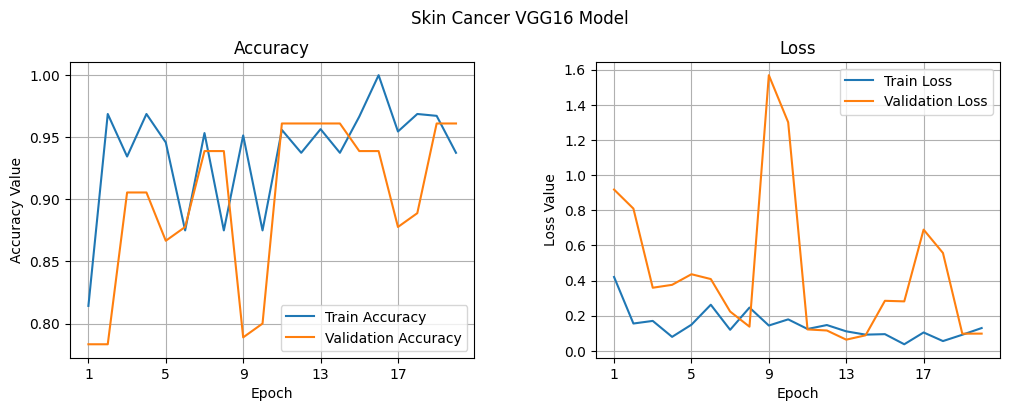

In [23]:
import matplotlib.pyplot as plt
plt.style.use('default')
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Skin Cancer VGG16 Model', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,21))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.grid()
ax1.set_xticks(np.arange(1, 21, 4))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.grid()
ax2.set_xticks(np.arange(1, 21, 4))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")
plt.savefig('curve1',dpi=400)

In [24]:
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(Y_test,axis=1)
print(classification_report(y_test_new,pred))

19/19 ━━━━━━━━━━━━━━━━━━━━ 13s 660ms/step
              precision    recall  f1-score   support

           0       0.88      0.97      0.92       393
           1       0.93      0.74      0.82       207

    accuracy                           0.89       600
   macro avg       0.90      0.86      0.87       600
weighted avg       0.90      0.89      0.89       600



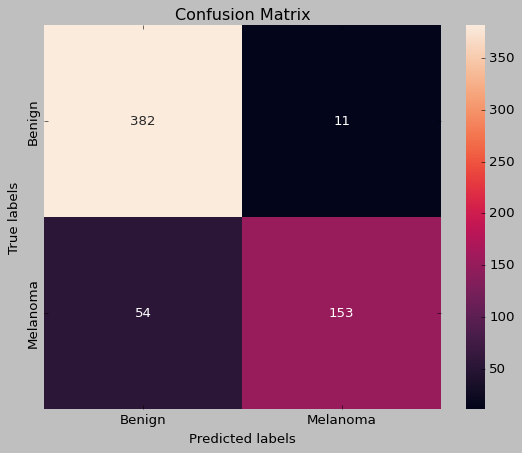

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='d', ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(['Benign', 'Melanoma']); ax.yaxis.set_ticklabels(['Benign', 'Melanoma'])
plt.savefig('CM_heatmap',dpi=400)

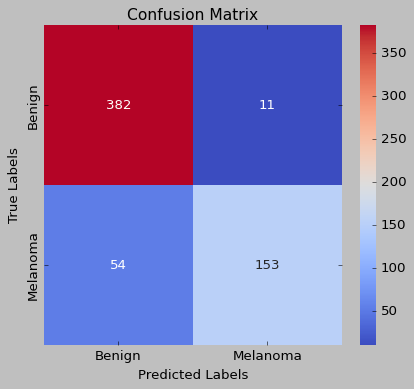

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create the figure and axis
fig, ax = plt.subplots(figsize=(6,5))  # Adjust size if needed

# Plot the heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm', ax=ax)

# Labels, title, and ticks
ax.set_xlabel('Predicted Labels', fontsize=12)
ax.set_ylabel('True Labels', fontsize=12)
ax.set_title('Confusion Matrix', fontsize=14)
ax.xaxis.set_ticklabels(['Benign', 'Melanoma'])
ax.yaxis.set_ticklabels(['Benign', 'Melanoma'])

# Save with better formatting
plt.savefig('CM_heatmap.png', dpi=400, bbox_inches='tight', transparent=True)
plt.show()


In [27]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score,confusion_matrix, roc_curve, auc,roc_auc_score,matthews_corrcoef,cohen_kappa_score

print('Accuracy: %.4f' % accuracy_score(y_test_new, pred), 'Precision: %.4f' % precision_score(y_test_new, pred),' Recall: %.4f' % recall_score(y_test_new, pred),
      'F1 Score: %.4f' % f1_score(y_test_new, pred), 'AUC Score: %.4f' % roc_auc_score(y_test_new, pred),'MCC: %.4f' % matthews_corrcoef(y_test_new, pred),
      'Kappa: %.4f' % cohen_kappa_score(y_test_new, pred))

Accuracy: 0.8917 Precision: 0.9329  Recall: 0.7391 F1 Score: 0.8248 AUC Score: 0.8556 MCC: 0.7585 Kappa: 0.7479


In [28]:
TP=cm[1,1]
TN=cm[0,0]
FP=cm[0,1]
FN=cm[1,0]
print('TP: %f' % TP,'TN: %f' % TN, 'FP: %f' % FP, 'FN: %f' % FN)

TP: 153.000000 TN: 382.000000 FP: 11.000000 FN: 54.000000


In [31]:
specificity=TN/float(TN+FP)
print('Specificity: %.4f' % specificity)
recall=TP/float(TP+FN)
print(' Recall: %.4f' % recall)
precision=TP/float(TP+FP)
print(' Precision: %.4f' % precision)
f1=(2*precision*recall)/(recall+precision)
print('F1 Score: %.4f' % f1)
print( 'AUC Score: %.4f' % roc_auc_score(y_test_new, pred))
from sklearn.metrics import mean_squared_error
print( 'Error Rate: %.5f' % mean_squared_error(y_test_new, pred))
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import cohen_kappa_score

print('MCC: %.4f' % matthews_corrcoef(y_test_new, pred), 'Kappa: %.4f' % cohen_kappa_score(y_test_new, pred))

Specificity: 0.9720
 Recall: 0.7391
 Precision: 0.9329
F1 Score: 0.8248
AUC Score: 0.8556
Error Rate: 0.10833
MCC: 0.7585 Kappa: 0.7479


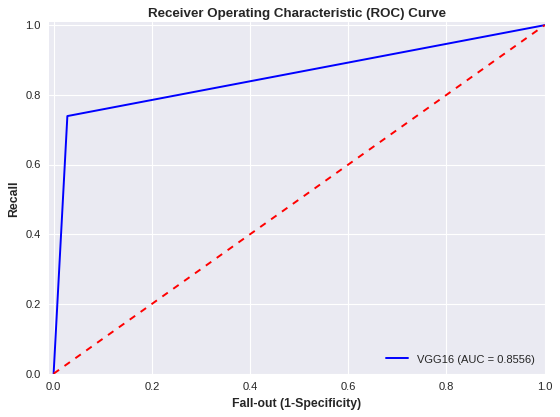

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("seaborn-v0_8")
#Print Area Under Curve
false_positive_rate, recall, thresholds = roc_curve(y_test_new, pred)
roc_auc = auc(false_positive_rate, recall)
plt.figure()
plt.title('Receiver Operating Characteristic (ROC) Curve', fontweight='bold')
plt.plot(false_positive_rate, recall, 'b', label = 'VGG16 (AUC = %0.4f)' %roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([-0.01,1.0])
plt.ylim([0.0,1.01])
plt.ylabel('Recall', fontweight='bold')
plt.xlabel('Fall-out (1-Specificity)', fontweight='bold')
plt.savefig('AUC curve',dpi=400)
plt.show()

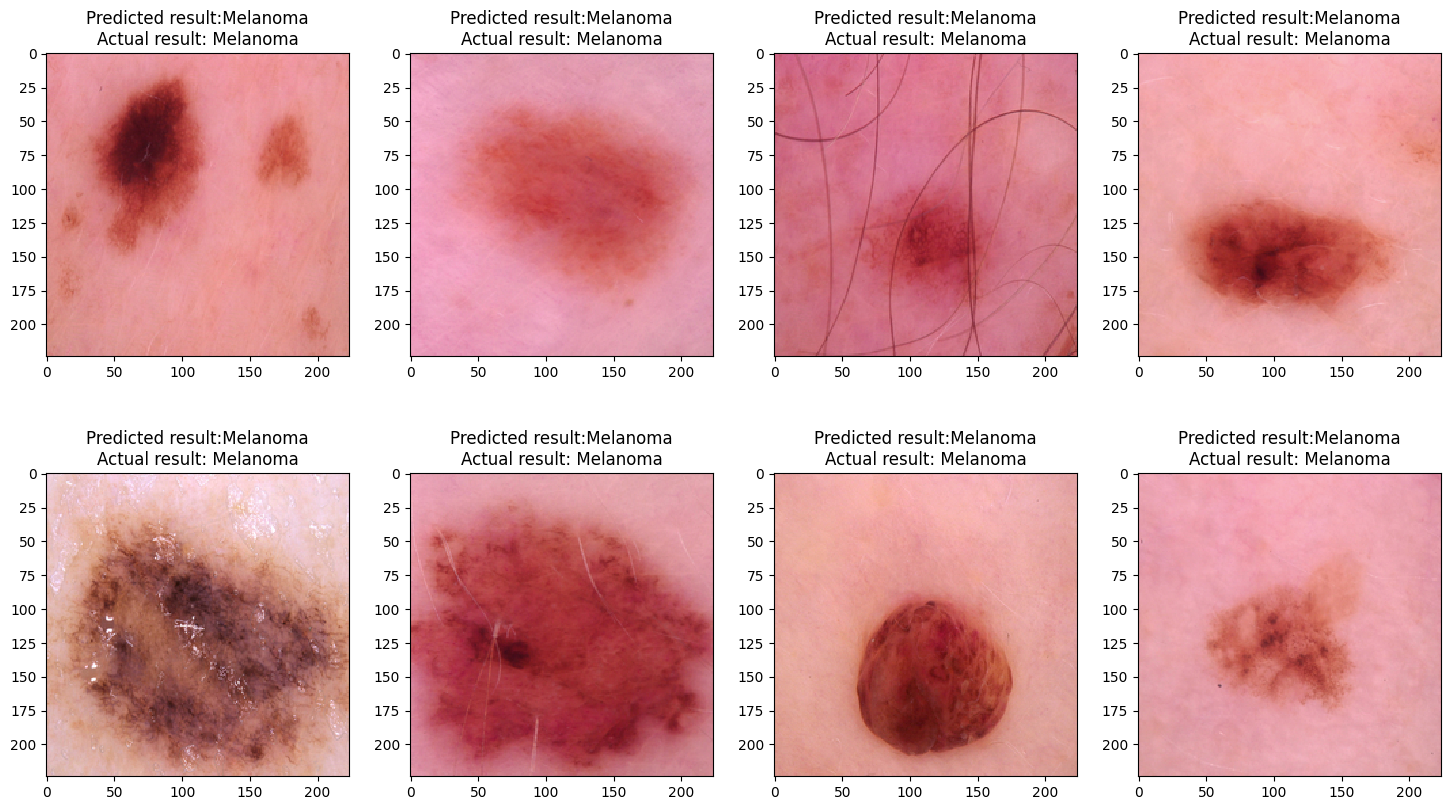

In [36]:
plt.style.use('default')
i=0
prop_class=[]
mis_class=[]
for i in range(len(Y_test)):
    if(np.argmax(Y_test[i])==np.argmax(pred[i])):
        prop_class.append(i)
    if(len(prop_class)==8):
        break

i=0
for i in range(len(Y_test)):
    if(not np.argmax(Y_test[i])==np.argmax(pred[i])):
        mis_class.append(i)
    if(len(mis_class)==8):
        break

w=60
h=40
fig=plt.figure(figsize=(18, 10))
columns = 4
rows = 2

def Transfername(namecode):
    if namecode==1:
        return "Benign"
    else:
        return "Melanoma"

for i in range(len(prop_class)):
    ax = fig.add_subplot(rows, columns, i+1)
    ax.set_title("Predicted result:"+ Transfername(np.argmax(pred[prop_class[i]]))
                       +"\n"+"Actual result: "+ Transfername(np.argmax(Y_test[prop_class[i]])))
    plt.imshow(X_test[prop_class[i]], interpolation='nearest')
plt.savefig('prediction',dpi=400)
plt.show()